After fixing the IoU metric in the previous model, the values seemed to be more in line with what I saw visually in the train/val videos. Next, I will add significantly more positive and negative augmented examples to see if the model can fit better. Given significantly more examples, I will also reduce the learning rate slightly.

In [1]:
%load_ext autoreload
%autoreload 2
import project_utils_multi

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
# tf.get_logger().setLevel('INFO')
# tf.autograph.set_verbosity(1)
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('Invalid device. Error.')
    pass

from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

from random import randint
import numpy as np

RANDOM_SEED = 0
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
EPOCHS = 100
LEARNING_RATE = 0.00005
ES_PATIENCE = 10
ES_RESTORE_WEIGHTS = True
PLAY_VIDEOS = True

In [2]:
df_train = project_utils_multi.load_image_dataframes('./data/train/', 'annotations.json')
display(df_train)

,id,confidence,y1,x1,y2,x2
0,00001.jpg,1.0,152.0,140.0,397.0,346.0
1,00002.jpg,1.0,144.0,140.0,403.0,345.0
2,00003.jpg,1.0,142.0,138.0,402.0,346.0
3,00004.jpg,1.0,144.0,140.0,405.0,344.0
4,00005.jpg,1.0,141.0,140.0,407.0,344.0
...,...,...,...,...,...,...
31081,31082.jpg,0.0,0.0,0.0,0.0,0.0
31082,31083.jpg,0.0,0.0,0.0,0.0,0.0
31083,31084.jpg,0.0,0.0,0.0,0.0,0.0
31084,31085.jpg,0.0,0.0,0.0,0.0,0.0


In [3]:
df_test = project_utils_multi.load_image_dataframes('./data/test/', 'annotations.json')
display(df_test)

,id,confidence,y1,x1,y2,x2
0,00001.jpg,1.0,220.0,252.0,411.0,437.0
1,00002.jpg,1.0,217.0,241.0,402.0,432.0
2,00003.jpg,1.0,229.0,252.0,416.0,443.0
3,00004.jpg,1.0,243.0,317.0,425.0,487.0
4,00005.jpg,1.0,274.0,332.0,457.0,510.0
...,...,...,...,...,...,...
107,00108.jpg,0.0,0.0,0.0,0.0,0.0
108,00109.jpg,0.0,0.0,0.0,0.0,0.0
109,00110.jpg,0.0,0.0,0.0,0.0,0.0
110,00111.jpg,0.0,0.0,0.0,0.0,0.0


In [4]:
train_datagen, validation_datagen = project_utils_multi.create_data_generators(df_train, ['confidence', 'y1', 'x1', 'y2', 'x2'], directory='./data/train/', test_split=0.2, seed=RANDOM_SEED)
test_datagen = project_utils_multi.create_data_generators(df_test, ['confidence', 'y1', 'x1', 'y2', 'x2'], directory='./data/test/', seed=RANDOM_SEED)
if PLAY_VIDEOS:
    display(project_utils_multi.play_images_from_sequence_datagen(train_datagen, num_to_iter=500))
    display(project_utils_multi.play_images_from_sequence_datagen(validation_datagen, num_to_iter=500))
    display(project_utils_multi.play_images_from_sequence_datagen(test_datagen, num_to_iter=25))

In [5]:
pos_neg = project_utils_multi.get_negative_positive_count('./data/train/', 'annotations.json')
print('Total Examples: ', pos_neg['positive'] + pos_neg['negative'])
print('Total positive: ', pos_neg['positive'])
print('Total negative: ', pos_neg['negative'])
print('Train positive: ', train_datagen.get_positive_count())
print('Train negative: ', train_datagen.get_negative_count())
print('Validation positive: ', validation_datagen.get_positive_count())
print('Validation negative: ', validation_datagen.get_negative_count())

Total Examples:  31086
Total positive:  20786
Total negative:  10300
Train positive:  16658
Train negative:  8210
Validation positive:  4128
Validation negative:  2090


80142336/80134624 [==============================] - 1s 0us/step
Epoch 1/100
777/777 [==============================] - 211s 255ms/step - loss: 68600.0067 - confidence_output_loss: 0.2537 - bounding_output_loss: 68599.7314 - confidence_output_binary_accuracy: 0.6172 - confidence_output_auc: 0.5611 - bounding_output_iou__metric: 0.1750 - val_loss: 29745.8809 - val_confidence_output_loss: 0.0713 - val_bounding_output_loss: 29745.8066 - val_confidence_output_binary_accuracy: 0.9195 - val_confidence_output_auc: 0.9734 - val_bounding_output_iou__metric: 0.3255
Epoch 2/100
777/777 [==============================] - 190s 244ms/step - loss: 25014.3842 - confidence_output_loss: 0.0546 - bounding_output_loss: 25014.3300 - confidence_output_binary_accuracy: 0.9313 - confidence_output_auc: 0.9827 - bounding_output_iou__metric: 0.3707 - val_loss: 15684.2861 - val_confidence_output_loss: 0.0273 - val_bounding_output_loss: 15684.2568 - val_confidence_output_binary_accuracy: 0.9718 - val_confidence_ou

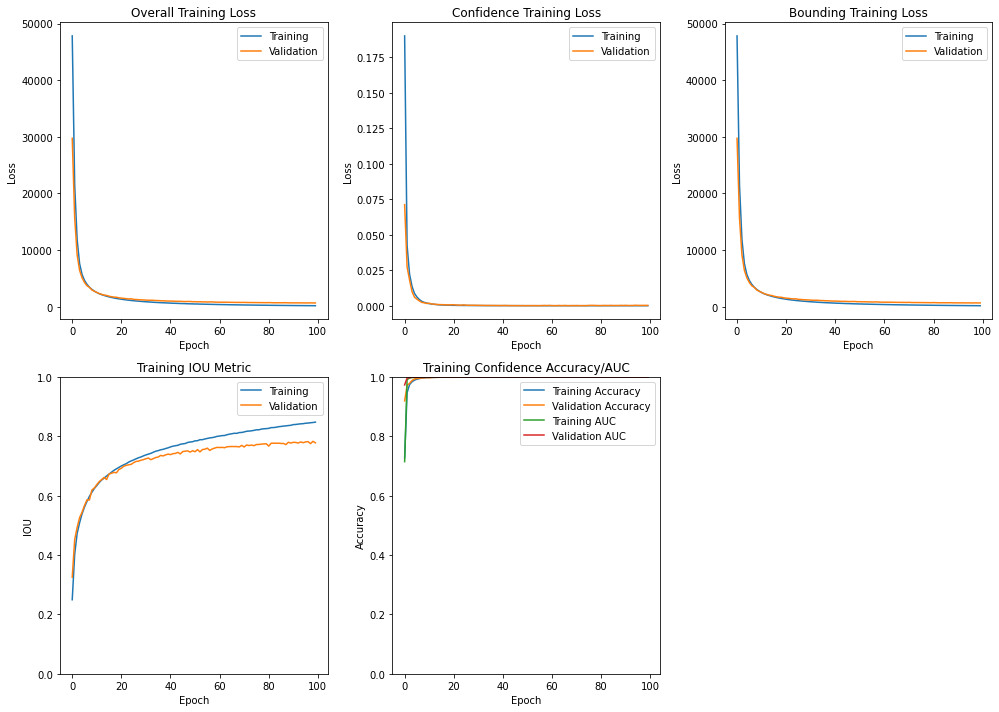

3/3 [==============================] - 1s 181ms/step - loss: 30375.1562 - confidence_output_loss: 0.0722 - bounding_output_loss: 30375.0879 - confidence_output_binary_accuracy: 0.9167 - confidence_output_auc: 0.9826 - bounding_output_iou__metric: 0.0867
Training Loss: 179.5559844970703
Training IOU: 2.1113664983030134e-10
Validation Loss: 674.4401245117188
Validation IOU: 0.00020647804194595665
Testing Loss: 30375.15625
Testing IOU: 0.07217510789632797


In [6]:
vgg = keras.applications.VGG19(weights='imagenet', include_top=False, input_tensor=keras.layers.Input(shape=(224, 224, 3)))
vgg.trainable = False

flatten = vgg.output
flatten = keras.layers.Flatten()(flatten)

hidden = keras.layers.Dense(1024, activation='relu')(flatten)

confHead = keras.layers.Dense(1, activation='sigmoid', name='confidence_output')(hidden)
bbHead = keras.layers.Dense(4, activation='linear', name='bounding_output')(hidden)

model = keras.models.Model(inputs=vgg.input, outputs=[confHead, bbHead])
opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss='mse', optimizer=opt, metrics=[[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()], [project_utils_multi.IOU_Metric()]])#, run_eagerly=True)


es = EarlyStopping(monitor='val_bounding_output_iou__metric', mode='max', verbose=1, patience=ES_PATIENCE, restore_best_weights=ES_RESTORE_WEIGHTS)
history = model.fit(train_datagen, 
                    steps_per_epoch=train_datagen.get_length() // BATCH_SIZE,
                    validation_data=validation_datagen, 
                    validation_steps = validation_datagen.get_length() // BATCH_SIZE,
                    epochs=EPOCHS, 
                    callbacks=[es])


In [ ]:
project_utils_multi.plot_history(history)
train_results = model.evaluate(train_datagen)
validation_results = model.evaluate(validation_datagen)
test_results  = model.evaluate(test_datagen)
print('Training Loss: {}\nTraining IOU: {}'.format(train_results[0], train_results[-1]))
print('Validation Loss: {}\nValidation IOU: {}'.format(validation_results[0], validation_results[-1]))
print('Testing Loss: {}\nTesting IOU: {}'.format(test_results[0], test_results[-1]))
project_utils_multi.write_results('./history.txt', model, history, train_datagen, validation_datagen)

In [8]:
if PLAY_VIDEOS:
    display(project_utils_multi.play_images_from_sequence_datagen(train_datagen, model=model, num_to_iter=500))

In [9]:
if PLAY_VIDEOS:
    display(project_utils_multi.play_images_from_sequence_datagen(validation_datagen, model=model, num_to_iter=250))

In [10]:
if PLAY_VIDEOS:
    display(project_utils_multi.play_images_from_sequence_datagen(test_datagen, model=model, num_to_iter=1))

In [11]:
if PLAY_VIDEOS:
    display(project_utils_multi.play_images_from_video('../../data/original/test_videos/hand_signs_webcam.mp4', model=model))

In [12]:
if PLAY_VIDEOS:
    display(project_utils_multi.play_images_from_video('../../data/original/test_videos/hand_signs_hand_only.mp4', model=model))